In [1]:
import pandas as pd
from datetime import date
from pathlib import Path
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans

import opinionated  # noqa
import matplotlib.pyplot as plt
plt.style.use("opinionated_rc")
import colormaps as cmaps
import seaborn as sns

# Get the bold color map values
PALETTE_BOLD = cmaps.bold._colors
sns.set_palette(PALETTE_BOLD)

CITY_SHORTCODE_NAME_LUT = {
    "AA": "Ann Arbor",
    "RO": "Royal Oak",
    "AP": "Alpena",
    "CS": "Cedar Springs",
    "GA": "Garden City",
    "IN": "Inkster",
    "JS": "Jackson",
    "LS": "Lansing",
    "LV": "Lathrup Village",
    "LN": "Livonia",
    "MH": "Madison Heights",
    "MT": "Manistee",
    "MP": "Memphis",
    "MC": "Mt Clemens",
    "PE": "Perry",
    "PR": "Pleasant Ridge",
    "RM": "Richmond",
    "SL": "Saline",
    "SC": "St Clair",
    "SH": "Sterling Heights",
    "WT": "Williamston"
}

ANNOTATIONS_DIR = Path("../data/annotated-for-modeling/").resolve()

/Users/evamaxfield/micromamba/envs/cdp-pc-seg/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [2]:
# Store all data to single object
data_dfs = []

def split_short_name_to_city_and_date(short_name: str) -> tuple[str, date]:
    # Split the short name into city and date
    short_code_and_date_parts = short_name.split("_")
    
    # Short code is the first part
    short_code = short_code_and_date_parts[0]

    # Date is the rest in month day two-digit-year format
    event_date = date(
        year=int("20" + short_code_and_date_parts[-1]),
        month=int(short_code_and_date_parts[1]),
        day=int(short_code_and_date_parts[2]),
    )

    return short_code, event_date

# Read all data
for filepath in ANNOTATIONS_DIR.glob("*.csv"):
    # Read the comment data
    df = pd.read_csv(filepath)

    # Lowercase all columns
    df.columns = df.columns.str.lower()

    # Remove any spaces from column names and replace with "_"
    df.columns = df.columns.str.replace(" ", "_")

    # Split the "name" column into "city" and "date"
    df["city"], df["date"] = zip(
        *df["name"].apply(split_short_name_to_city_and_date),
        strict=True,
    )

    # Add a year-month column
    df["year_month"] = df["date"].apply(lambda x: x.replace(day=1))

    # Add the truth data to the list
    data_dfs.append(df)

# Concatenate all training data
full_data = pd.concat(data_dfs)
full_data.head()

,name,speaker,text,start,end,transition,meeting_section,speaker_role,is_public_comment,is_public_hearing,is_comment_start_trigger,is_comment_end_trigger,is_hearing_start_trigger,is_hearing_end_trigger,city,date,year_month,model_pred_public_comment,model_pred_public_hearing
0,IN_01_03_23,SPEAKER_10,"Good evening, everyone, and welcome to the fir...",91.0,107.0,"""""",Other,Other,0,0,0,0,0,0,IN,2023-01-03,2023-01-01,NaN,NaN
1,IN_01_03_23,SPEAKER_05,"Let us pray. Father God, we come no other way ...",107.0,124.0,"""""",Other,Other,0,0,0,0,0,0,IN,2023-01-03,2023-01-01,NaN,NaN
2,IN_01_03_23,SPEAKER_10,All rise to pledge allegiance to the flag. I p...,124.0,148.0,"""""",Other,Other,0,0,0,0,0,0,IN,2023-01-03,2023-01-01,NaN,NaN
3,IN_01_03_23,SPEAKER_00,Councilmember Williams.,149.0,152.0,"""""",Other,Other,0,0,0,0,0,0,IN,2023-01-03,2023-01-01,NaN,NaN
4,IN_01_03_23,SPEAKER_05,Here.,152.0,153.0,"""""",Other,Other,0,0,0,0,0,0,IN,2023-01-03,2023-01-01,NaN,NaN


In [3]:
# Filter out government comments and only use public comment not hearing
meeting_comments = full_data[
    (full_data["meeting_section"] == "Public Comment")
    & (full_data["speaker_role"] == "Commenter")
]

In [4]:
# Init topic model and pipeline components
cluster_model = MiniBatchKMeans(n_clusters=30, random_state=0)
vectorizer_model = TfidfVectorizer(stop_words="english", max_df=30,min_df=3, lowercase=True)
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True, bm25_weighting=True)
umap_model = PCA(n_components=10)

topic_model = BERTopic(umap_model=umap_model,
                       hdbscan_model=cluster_model,
                       ctfidf_model=ctfidf_model,
                       vectorizer_model=vectorizer_model)

In [5]:
# Fit transform all data
topics, _ = topic_model.fit_transform(meeting_comments.text)

# Store topics in the dataframe
meeting_comments["topic_id"] = topics

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [6]:
# Get topic info and manually write topic names
topic_info = topic_model.get_topic_info()

# Print each topic and their representative docs
for _, row in topic_info.iterrows():
    print(f"Topic Id: {row['Topic']}")
    print(f"Short representation: {row['Representation']}")
    for doc in row["Representative_Docs"][:3]:
        print(f"\tExample Doc: {doc}")
        print("\n")
    
    print("\n" + "="*80 + "\n")

Topic Id: 0
Short representation: ['okay', 'heavenly', 'hi', 'lord', 'ill', 'father', 'ok', 'shame', 'andrea', 'hello']
	Example Doc: They represent the Lord, yeah. I represent my heavenly Father.


	Example Doc: I agree that I know. Thank you. Okay. I was a little worried. Like did I miss something? I thought I read my material. I'm nervous right now. I just want to make sure it's on everybody's agenda.


	Example Doc: Okay. Sorry. Again, a lot of this information came to me at last minute. I'll see you tomorrow. All right. Okay. Thank you for hearing me out. Thank you, sir.




Topic Id: 1
Short representation: ['parking', 'meters', 'traffic', 'lanes', 'feet', 'art', 'road', 'car', 'dda', 'oak']
	Example Doc: Good evening. I'm Mike Echmelina. I've been living in Royal Oak for 20 years. I live at 1005 East 3rd Street. I'm about four blocks directly east of this building. Normally, I probably would have walked here this evening, but given the rain and the weather, I chose to drive. And

In [7]:
# Create topic_id to topic_name mapping
topic_id_to_name_lut = {
    0: "Undefined",
    1: "Undefined",
    2: "Transportation and Infrastructure",  # Parking
    3: "Housing",  # Second chance housing
    4: "Public Amenities",  # Art in public spaces
    5: "Budget and Finance",
    6: "Undefined",
    7: "Comprehensive Planning and Zoning",
    8: "Social Justice",  # Racial Equity and Discrimination
    9: "Comprensive Planning and Zoning",  # Zoning
    10: "Undefined",
    11: "Community Events",
    12: "Utilies and Services",  # Water and Sewer
    13: "Community Services",  # Mental health and disability services
    14: "Budget and Finance",
    15: "Licenses and Permits",  # Animal control and pets
    16: "Government Accountability",  # Greivances
    17: "Homelessness",
    18: "Comprensive Planning and Zoning",
    19: "Social Justice",  # Israel Palestine
    20: "Police and Public Safety",
    21: "Comprehensive Planning and Zoning",  # Parks, transportation, amenities
    22: "Police and Public Safety",
    23: "Social Justice",  # Israel Palestine
    24: "Community Events",
    25: "Housing",  # Renters rights
    26: "Housing",  # Affordable housing
    27: "Homelessness",
    28: "Administration",  # Tickets and Fines
    29: "Housing",

}

# Map the topic names to the dataframe
meeting_comments["topic_name"] = meeting_comments["topic_id"].map(topic_id_to_name_lut)
meeting_comments.topic_name.value_counts()

Undefined                            207
Housing                               98
Social Justice                        90
Budget and Finance                    77
Comprehensive Planning and Zoning     67
Comprensive Planning and Zoning       64
Community Events                      58
Police and Public Safety              55
Transportation and Infrastructure     50
Homelessness                          49
Public Amenities                      46
Community Services                    33
Utilies and Services                  33
Licenses and Permits                  32
Government Accountability             32
Administration                        15
Name: topic_name, dtype: int64

In [8]:
# Filter out all undefined topics
meeting_comments = meeting_comments[meeting_comments["topic_name"] != "Undefined"]

# Plotting comments
# Drop any cities with less than 4 months of data
city_counts = meeting_comments.groupby("city")["year_month"].nunique()
valid_cities = city_counts[city_counts >= 4].index
plotting_comments = meeting_comments[meeting_comments["city"].isin(valid_cities)]

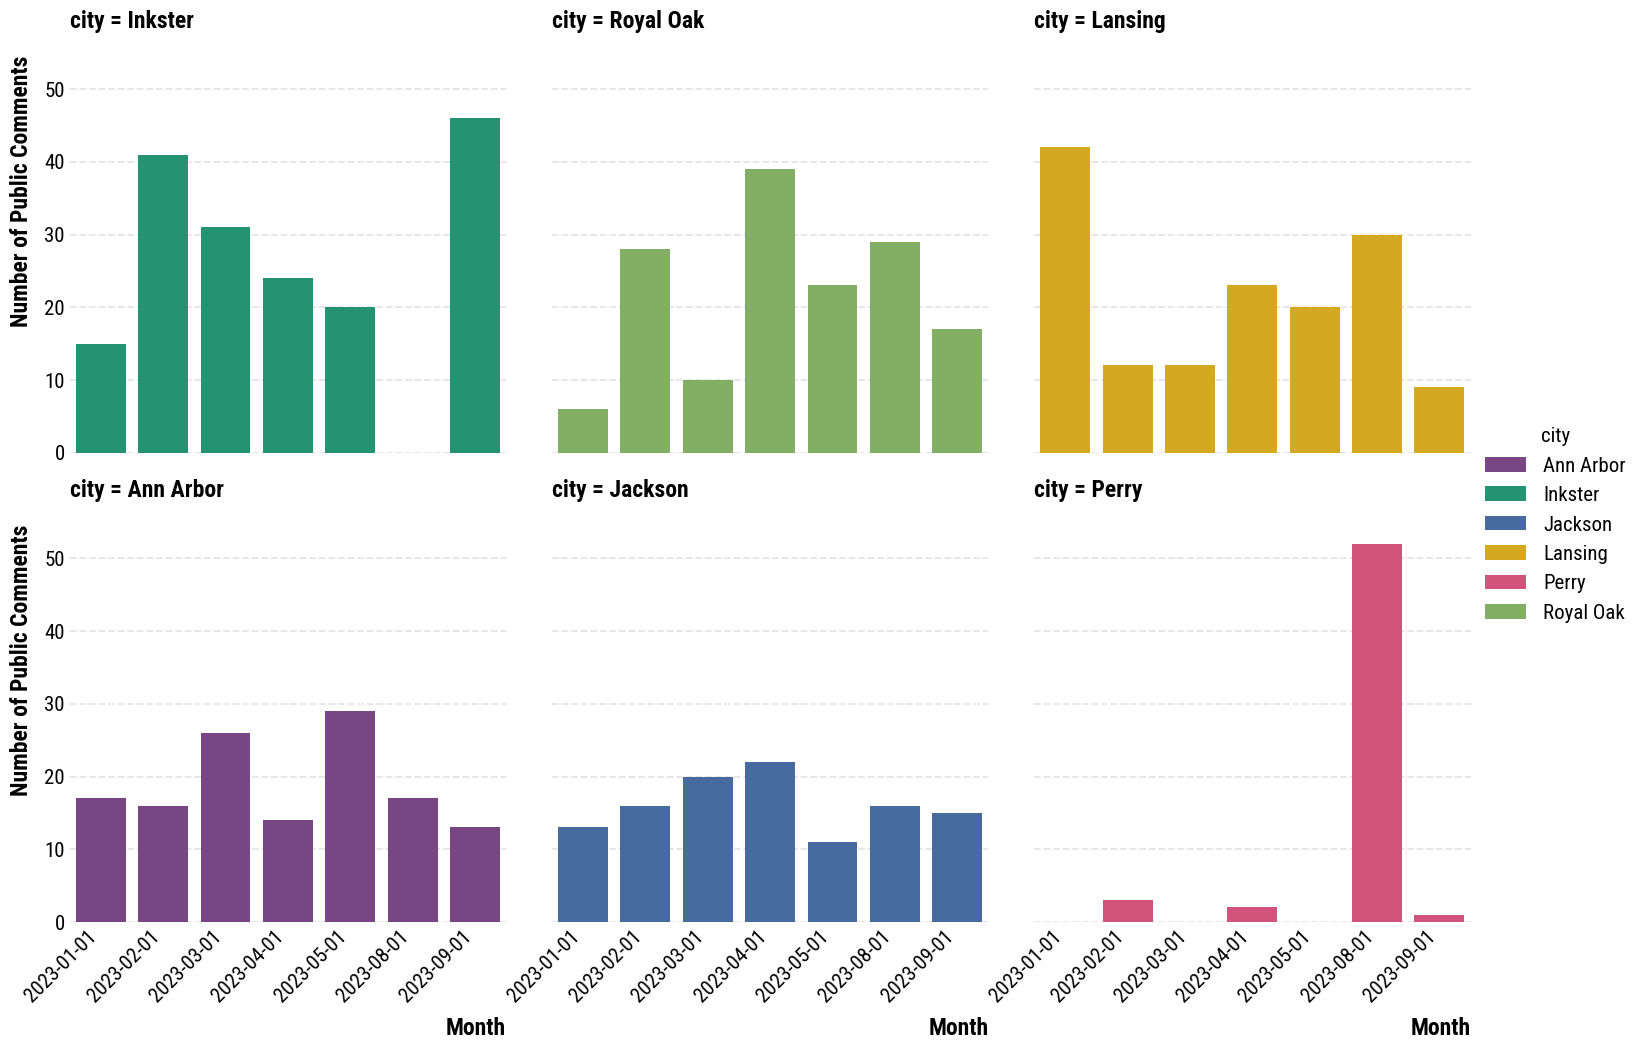

In [9]:
# Create a bar plot of the number of comments per month per city
city_month_counts = plotting_comments.groupby(["city", "year_month"]).size().reset_index(name="comment_count")
city_month_counts = city_month_counts.replace({"city": CITY_SHORTCODE_NAME_LUT})

# Create dataframe of average number of comments per month per city
city_avg_month_counts = city_month_counts.groupby("city").mean().reset_index()
col_order = city_avg_month_counts.sort_values("comment_count", ascending=False)["city"]

# Col by city
g = sns.catplot(
    data=city_month_counts,
    x="year_month",
    y="comment_count",
    hue="city",
    col="city",
    col_wrap=3,
    col_order=col_order,
    kind="bar",
    palette=PALETTE_BOLD,
)

# Rotate all subplot x-axis tick labels
for ax in g.axes.flat:
    # Check if x-axis tick labels are present
    if ax.get_xticklabels():
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

# Update the x-axis, and y-axis labels
g.set_axis_labels("Month", "Number of Public Comments")

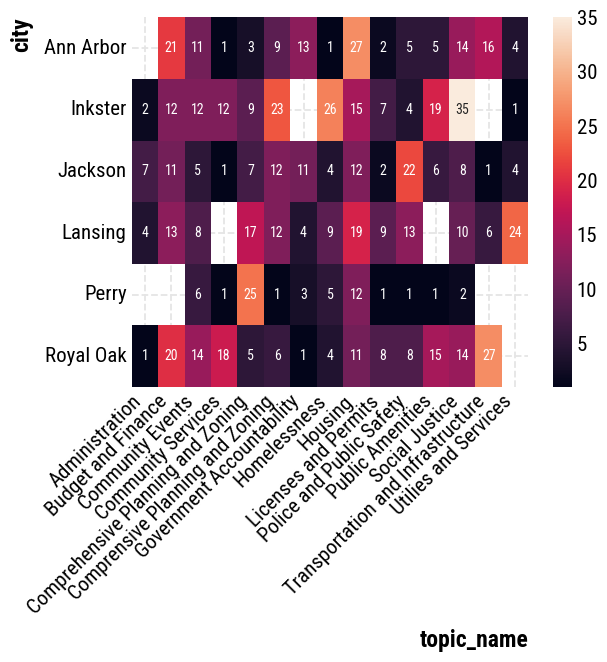

In [10]:
# Calculate percent of topic per month per city
plotting_comments = plotting_comments.replace({"city": CITY_SHORTCODE_NAME_LUT})

# Create topic name and city count dataframe
topic_city_counts = plotting_comments.groupby(["city", "topic_name"]).size().reset_index(name="comment_count")

# Convert to percentage and store in new frame
topic_city_counts["comment_pct"] = topic_city_counts.groupby("city")["comment_count"].transform(lambda x: x / x.sum())

# Heatmap of topic percentage per month per city
sns.heatmap(
    data=topic_city_counts.pivot(index="city", columns="topic_name", values="comment_count"),
    annot=True,
)
_ = plt.xticks(rotation=45, ha="right")

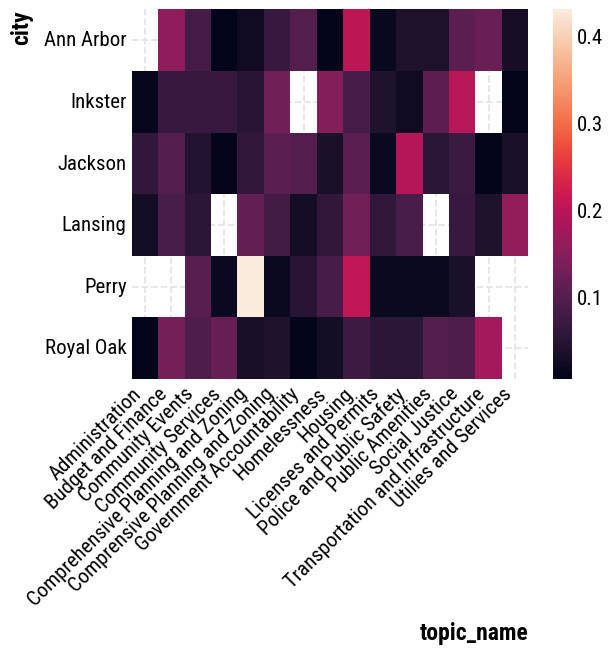

In [11]:
# Heatmap of topic percentage per month per city
sns.heatmap(
    data=topic_city_counts.pivot(index="city", columns="topic_name", values="comment_pct"),
    # annot=True,
)
_ = plt.xticks(rotation=45, ha="right")

In [12]:
# UMAP and scatter plot
import umap
from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer("all-MiniLM-L12-v2")
umap_model = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42)

# Generate embeddings for all text
embeddings = embed_model.encode(meeting_comments.text.tolist(), show_progress_bar=True)
meeting_comments["umap_x"], meeting_comments["umap_y"] = umap_model.fit_transform(embeddings).T

Batches: 100%|██████████| 25/25 [00:02<00:00,  9.98it/s]
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


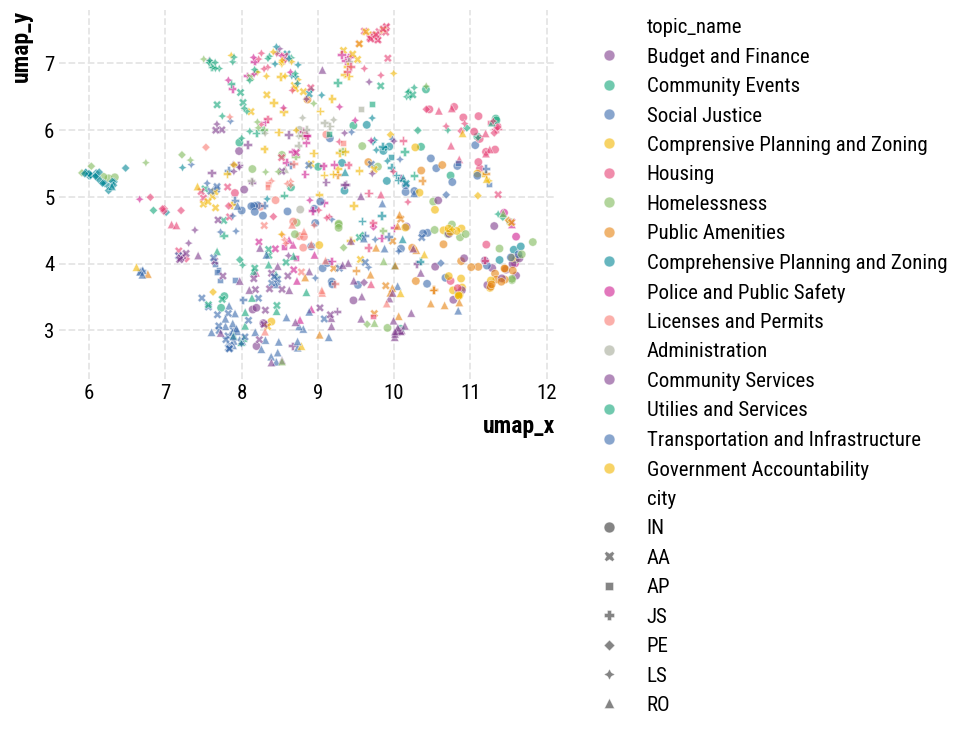

In [13]:
# Plot the UMAP scatter plot
sns.scatterplot(
    data=meeting_comments,
    x="umap_x",
    y="umap_y",
    hue="topic_name",
    style="city",
    palette=PALETTE_BOLD,
    alpha=0.6,
)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)